# 機械学習の実行

-----------------
## ①各種ライブラリの読み込み

### ①－１：必要なライブラリの読み込み
以下のライブラリが必要となるため、順に読み込みます。<br>
ソースコード内で何回も記述することになるものは、別名をasでつけると良いでしょう。<br>
pandasはpd, numpyはnpと別名をつけるのが一般的です。
<ul>
    <li>データ整形　・・・ numpy、　pandas </li>
    <li>可視化 ・・・ matplotlib.pyplot </li>
    <li>機械学習アルゴリズム ・・・　sklearn.ensemble.RandomForestClassifier, sklearn.svm.SVC </li>
    <li>機械学習の結果評価 ・・・ sklearn.metrics.accuracy_score, sklearn.metrics.confusion_matrix  </li>
    <li>モデルの保存/読み込み　・・・ pickle
</ul>

In [1]:
#---------------------------------------
#  各種ライブラリの読み込み①
#---------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix

import pickle

### ①－２：乱数シードの指定
再現性のある分析とするために、numpyの乱数シードを固定しておきます。

In [2]:
np.random.seed(123) # 乱数を使う場合、再現性を保つためSEEDを指定

----------
## ②データの取り込み、データ分割

### ②－１：データの取り込み
文字列を含む項目があるため、pandasを使いデータを取り込みます。<br>
csv形式のデータなので、read_csvを使って取り込みましょう。

In [3]:
#---------------------------------------
#  データの取り込み、データ分割②
#---------------------------------------
df = pd.read_csv("car_braking.csv")

### ②－２：データの分割
scikit-learnが提供するtrain_test_split関数でも良いですが、ここではnumpyを活用した例を紹介します。<br>
データを学習、検証、評価に６対２対２の比率で分割します。<br>
そのためにまず全体のレコード数をlen(df)で求め、そこに各データの比率を掛けて、それぞれのデータ件数を求めます。<br>
intで囲っているのは、レコード件数を整数にするためです。これをキャスティングといいます。<br>
np.random.permutationを使って作られたperm_idxはランダムに並び替えられたインデックス値になります。<br>
perm_idxを前から順に6割、2割、2割とデータを取得すると、無作為抽出（ランダムサンプリング）されたデータセットができます。

In [4]:
train_num = int( len(df) * 0.6 ) # 6割を学習データ
val_num = int( len(df) * 0.2 )   # 2割を検証データ

perm_idx = np.random.permutation( len(df) ) # ランダムなインデックス
# perm_idxの先頭から6割までを学習用インデックスにする
train_idx = perm_idx[ : train_num ]
# perm_idxの先頭6割から8割までを検証用のインデックスにする
val_idx = perm_idx[ train_num : (train_num + val_num) ]
# perm_idxの先頭8割以降をテスト用のインデックスにする
test_idx = perm_idx[ (train_num + val_num) : ]

train_df = df.iloc[ train_idx, : ] # 学習用インデックス値で行抽出
val_df = df.iloc[ val_idx, : ]     # 検証用インデックス値で行抽出
test_df = df.iloc[ test_idx, : ]   # テスト用インデックスで行抽出

--------
## ③教師ラベルの加工
ここでは分類問題を考えますが、データにはブレーキを踏む・踏まないという教師ラベルがありません。<br>
停止距離(measured_braking_distance)がデータ上にあるので、この値と前方物体までの距離を比較して教師ラベルを作ります。<br>
ブレーキを踏む場合は１、踏まない場合は０とします。<br>
1サンプルにつき物体までの距離を5パターン用意します。<br>

### ③－１：教師ラベル作成用の関数作成
データを格納するための空のデータフレーム(container_df)を作ります。<br>
pd.DataFrameでデータフレームを呼び出し、その後ろにdictionary形式で変数名と空のリストを与えます。<br>
{　変数名1:[], 変数名2:[] }といった具合です。<br><br>
次に、説明変数として使う項目をリスト形式でデータフレームに与えます。<br>
このデータフレームをtemp_dfとします。<br><br>
続いて、物体までの距離の生成するためにnp.random.uniformを使い一様分布の乱数を生成します。<br>
この乱数を使い、停止距離の50%から150%の範囲で物体まで距離を生成します。<br><br>
停止距離と物体までの距離の大小関係から教師ラベルを作ります。<br>
物体までの距離（distance_to_object）と教師ラベル(hit_brake)をtemp_dfのデータフレームに追加します。<br><br>
container_dfにtemp_dfを追加します。<br><br>
この一連の処理を引数に与えているsamplesの回数だけ繰り返します。<br>

In [5]:
#---------------------------------------
#  教師ラベルの加工③
#---------------------------------------
# ここでは分類問題として考える。
# 車重、車速、タイヤ幅、路面、物体までの距離を与えたときに、
# ブレーキを踏む必要があるかを判定するロジックを作る。
# 教師ラベルはブレーキを踏む場合１、踏まない場合は０とする。
# 0と１の教師ラベルを停止距離(measured_braking_distance)と
# 乱数生成で作った物体までの距離で作る
# 1サンプルにつき、物体までの距離が異なるサンプルを5個作る
# 停止距離<=物体までの距離のときブレーキを踏むとする。

def create_label( samples, input_df ):
    # samplesは、１計測結果につき作るサンプル数。この例では5。
    # input_dfは、入力するデータフレーム
    
    # 空のデータフレームのコンテナを作成。ここにデータを足していく。
    container_df = pd.DataFrame( {'car_weight'         : [], # 車重
                                  'car_velocity'       : [], # 車速
                                  'tire_width'         : [], # タイヤ幅
                                  'road_type'          : [], # 路面
                                  'distance_to_object' : [], # 物体までの距離
                                  'hit_brake'          : []} ) # ブレーキ要否
    for i in range(samples):
        temp_df = input_df[ ['car_weight', 'car_velocity', \
                            'tire_width', 'road_type'] ] #列指定
        # 停止距離の50%～150%でサンプルを作る。
        # numpyのuniform関数で一様分布の乱数を生成して、停止距離に掛ける。
        random_distance = input_df['measured_braking_distance'] \
                          * np.random.uniform( 0.5, 1.5, len(input_df) )
        # 停止距離がランダムな距離以下の時１、そうでない場合は0とする。
        # これを教師ラベルとする。
        # リストにif-else処理をして、別のリストを作る方法
        # [TRUE時の処理 if 条件 else FALSE時の処理 for文]
        labels = [ 1. if \
                        (input_df['measured_braking_distance']).iloc[j] \
                        <= random_distance.iloc[j] \
                      else \
                        0. \
                      for j in range( len(input_df) ) ]
        # ランダムな距離をデータフレームに格納
        temp_df['distance_to_object'] = random_distance
        # ラベルをデータフレームに格納
        temp_df['hit_brake'] = labels
        # データをコンテナのデータフレームに追加
        container_df = pd.concat([container_df, temp_df])
    return container_df

### ③－２：学習、検証、評価データに教師ラベル作成用の関数を適用
教師ラベル作成用の関数を各データセットに適用します。<br>
1サンプルにつき物体までの距離を5パターン用意するので、一つ目の引数を5にしています。<br>
こうして作られるtrain_df2, val_df2, test_df2は説明変数と目的変数（教師ラベル）の両方を含んでいるため、目的変数を別変数として取り出しておきます。<br>
なお、命名する際は説明変数となるものにxを、目的変数となるものにｙをつけるのが慣例です。

In [6]:
# 学習、検証、テストデータの各サンプルについて5個教師ラベルを作る
train_df2 = create_label(5, train_df)
val_df2 = create_label(5, val_df)
test_df2 = create_label(5, test_df)

train_y = np.array(train_df2['hit_brake'])
val_y = np.array(val_df2['hit_brake'])
test_y = np.array(test_df2['hit_brake'])

-----------------
## ④カテゴリ変数をダミー変数に変換

カテゴリ変数とは、通常の変数とは違い連続値ではなく離散値の説明変数です。<br>
この例のように文字列だけでなく、数値もカテゴリ変数になりえます。<br>
例えば、店舗コードなどは数字で記録されますが、数値の大小関係に意味はないためカテゴリ変数として扱うのが適切です。<br>
こういった説明変数を扱う際は、ダミー変数化をします。<br>
ダミー変数化すると、元々の説明変数を除外し、代わりに説明変数のユニーク値が項目になります。<br>
路面状態のユニーク値は３つあるため、ダミー変数を２つ用意すれば元データと同じ情報となります。<br>
※3つ目のユニーク値については、1つ目か2つ目かの情報があれば消去法で判断できるため不要

●元データ

|road_type|
|---|
|snow_road| 
|tarmac_dry|
|snow_road| 
|tarmac_wet|
|...| 
<br>

●ダミー変数化後

|snow_road|tarmac_dry|
|---|
|1|0| 
|0|1|
|1|0|
|0|0|
|...|...| 


### ④－１：ユニーク値の確認
ユニーク値の件数（同一の値の重複を取り除いた状態での件数）を確認します。<br>
np.unique()を使うことで重複を取り除き、ユニーク値を得ることができます。<br>

In [7]:
#---------------------------------------
#  カテゴリ変数をダミー変数に変換④
#---------------------------------------
# カテゴリ変数であるroad_type変数のユニーク値を調べる
unique_road_type = np.unique(df['road_type'])
print ("-unique road type------------------")
print(unique_road_type)

-unique road type------------------
['snow_road' 'tarmac_dry' 'tarmac_wet']


### ④－２：空のダミー変数の作成
ダミー変数はユニーク値が多くない場合は、ユニーク値－1です。<br>
ダミー変数の行数は元々のデータと同じなので、len()を使って件数を取得します。<br>
np.zerosですべての値が0の行列を作ります。<br>

In [8]:
# ダミー変数の数はダミー変数は（ユニーク値の数）-1になる。
# ユニーク値が多い場合は、「その他」にまとめるなどの工夫が必要だが、
# 今回は少ないためそのような対応は不要
dummy_cat_num = len(unique_road_type)-1 #ダミー変数の数
# 空のダミー変数を作成。この後のダミー変数化の処理で値を入れていく。
# np.zeros()はからの行列を作る。引数に行列の大きさを与える。
# 行数は学習、検証、テストデータの行数、列は（ユニーク値の数）-1
train_dummy_vars = np.zeros( (len(train_df2), dummy_cat_num) )
val_dummy_vars = np.zeros( (len(val_df2), dummy_cat_num) )
test_dummy_vars = np.zeros( (len(test_df2), dummy_cat_num) )

### ④－３：ダミー変数化
ダミー変数毎に以下の処理をします。<br>
元のデータの路面状態(road_type)を確認して、値が０か１かを判断して④－２で作ったからのダミー変数に反映させます。

In [9]:
# ダミー変数化
for i in range(dummy_cat_num): # ダミー変数の数だけループ
    this_road_type = unique_road_type[i] # ダミー変数化する路面を選択
    # 学習、検証、テストデータ上の路面が、今ダミー変数化したい路面だった場合に１、
    # そうでない場合に0にする。
    train_dummy_vars[:, i] = [ 1. if road_type == this_road_type else 0.\
                    for road_type in train_df2['road_type'] ] 
    val_dummy_vars[:, i] = [ 1. if road_type == this_road_type else 0. \
                  for road_type in val_df2['road_type']] 
    test_dummy_vars[:, i] = [ 1. if road_type == this_road_type else 0. \
                   for road_type in test_df2['road_type'] ] 

-----------------
## ⑤標準化
標準化とは、説明変数の平均を０にして、標準偏差を１にする処理です。<br>
機械学習のアルゴリズムの中には、説明変数毎にとる値の範囲が違いすぎると、学習が上手くいかないものがあります。<br>
このため、どの説明変数を見ても平均が０で標準偏差が１になるようにするのが良いとされます。<br>

### ⑤－１：平均と標準偏差の算出と保存
モデルを使うのに必要な説明変数のうち連続値であるものを取得します。<br>
学習データで、これら説明変数の平均と標準偏差を算出します。<br>
ここで求めた平均と標準偏差は後々必要なため、np.saveを使って保存しておきます。

In [10]:
train_x = np.array(train_df2[ ['car_weight', 'car_velocity', 'tire_width',\
                              'distance_to_object'] ]) # 連続値取得
mean_x = np.mean(train_x, axis = 0)
std_x = np.std(train_x, axis = 0)
np.save('mean_x.npy', mean_x) # 平均値の保存
np.save('std_x.npy', std_x)   # 標準偏差の保存

### ⑤－２：標準化処理
学習、検証、テストデータのそれぞれから⑤－１で求めた平均を引き、⑤－１で求めた標準偏差で割ります。

In [11]:
train_x -= mean_x #平均0
train_x /= std_x  #標準偏差1
train_x = np.hstack([train_x, train_dummy_vars]) # 連続値とダミー変数のマージ

val_x = np.array(val_df2[ ['car_weight', 'car_velocity', 'tire_width',\
                          'distance_to_object'] ]) # 連続値取得
val_x -= mean_x # 平均0
val_x /= std_x  # 標準偏差1
val_x = np.hstack([val_x, val_dummy_vars]) # 連続値とダミー変数のマージ

test_x = np.array(test_df2[ ['car_weight', 'car_velocity', 'tire_width',\
                            'distance_to_object'] ]) # 連続値取得
test_x -= mean_x # 平均0
test_x /= std_x  # 標準偏差1
test_x = np.hstack([test_x, test_dummy_vars]) # 連続値とダミー変数のマージ

-----------------
##  ⑥チューニングと検証データを用いた評価
SVMとランダムフォレストのそれぞれについて、ハイパーパラメータを変更しながら学習データに適合させてモデルを作っていきます。<br>
作ったモデルの性能を評価し、今までで一番よいモデルであればそのハイパーパラメータとモデルを保存します。<br><br>

最適なハイパーパラメータを見つけるためにグリッドサーチを行います。<br>
グリッドサーチを行う場合、まずはハイパーパラメータの候補値をリストでつくります。<br>
これらハイパーパラーメータの候補値リストをループさせて、全組み合わせについてモデルの作成、適合処理、検証を行います。<br><br>

モデルを作成するには、冒頭で読み込んだSVC()やRandomForetClassifier()を使います。<br>
それぞれのモデルからfitメソッドを呼び出して、学習データを与えて適合させます。<br><br>

適合させた結果、いいモデルができたかを検証データを用いて確認します。<br>
モデルからpredict()メソッドを呼び出し、検証データを与えて予測します、<br>
accuracy_score()で正解率を確認し、今までで一番よいモデルのコピーをとっておきます。<br>
※サンプルソースコードでは学習データでも予測と評価をしていますが、これは稀に学習データでも正解率が著しく低いことがあるためです。<br>
※学習データの段階で精度が得られない場合、検証データの精度を評価する意味がありません。<br>

### ⑥－１：SVMのチューニング
ハイパーパラメータであるC（誤分類コスト）とgamma（境界線の複雑さ）を変化させ、検証データでの精度を評価しながら最適なモデルを探します。

In [12]:
print ("-Tuning------------------")
best_val_acc_rf = 0.
best_val_acc_svm = 0.

# rbf SVC
print("SVC rbf") # SVMのチューニング
for c in [ 10000., 1000., 100., 10., 1., 0.1, 0.01]: # ハイパーパラメータ
    for g in ['auto', 0.001, 0.01, 0.1, 1., 10., 100. ]: # ハイパーパラメータ
        # ハイパーパラメータの組み合わせ毎にモデルを用意    
        clf = SVC(kernel = 'rbf', C = c, gamma = g, probability = True, random_state = 0)
        clf.fit(train_x, train_y) # フィッティング
        pred_train_y = clf.predict(train_x)               # 学習データで予測
        train_acc = accuracy_score(train_y, pred_train_y) # 学習データの正解率
        pred_val_y = clf.predict(val_x)             # 検証データで予測
        val_acc = accuracy_score(val_y, pred_val_y) # 検証データの正解率
        print( "c:%s\tgamma:%s\ttrain_acc:%.3f\tval_acc:%.3f" \
              %(c, g, train_acc, val_acc) )
        if best_val_acc_svm < val_acc: # 暫定ベストのモデルか確認
            best_val_param_svm = [c, g] # パラメータ格納
            best_clf_svm       = clf # モデルコピー
            best_val_acc_svm   = val_acc # ベストな正解率を更新

-Tuning------------------
SVC rbf
c:10000.0	gamma:auto	train_acc:0.919	val_acc:0.846
c:10000.0	gamma:0.001	train_acc:0.835	val_acc:0.824
c:10000.0	gamma:0.01	train_acc:0.879	val_acc:0.852
c:10000.0	gamma:0.1	train_acc:0.906	val_acc:0.853
c:10000.0	gamma:1.0	train_acc:0.974	val_acc:0.792
c:10000.0	gamma:10.0	train_acc:0.985	val_acc:0.751
c:10000.0	gamma:100.0	train_acc:0.991	val_acc:0.642
c:1000.0	gamma:auto	train_acc:0.906	val_acc:0.844
c:1000.0	gamma:0.001	train_acc:0.803	val_acc:0.792
c:1000.0	gamma:0.01	train_acc:0.862	val_acc:0.842
c:1000.0	gamma:0.1	train_acc:0.896	val_acc:0.845
c:1000.0	gamma:1.0	train_acc:0.956	val_acc:0.794
c:1000.0	gamma:10.0	train_acc:0.974	val_acc:0.763
c:1000.0	gamma:100.0	train_acc:0.984	val_acc:0.619
c:100.0	gamma:auto	train_acc:0.889	val_acc:0.840
c:100.0	gamma:0.001	train_acc:0.750	val_acc:0.742
c:100.0	gamma:0.01	train_acc:0.835	val_acc:0.827
c:100.0	gamma:0.1	train_acc:0.883	val_acc:0.838
c:100.0	gamma:1.0	train_acc:0.929	val_acc:0.799
c:100.0	gamma:1

### ⑥－２：ランダムフォレストのチューニング
ハイパーパラメータである作成するツリーの数と、作成するツリーの階層を変化させ、検証データでの精度を評価しながら最適なモデルを探します。

In [13]:
print("RF") # ランダムフォレストのチューニング
for n in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]: # ハイパーパラメータ
    for d in [1, 2, 5, 10, 20 ,50]: # ハイパーパラメータ
        # ハイパーパラメータの組み合わせ毎にモデルを用意
        clf = RandomForestClassifier(n_estimators = n,max_depth = d,random_state = 0)
        clf.fit(train_x, train_y) # フィッティング
        pred_train_y = clf.predict(train_x) # 学習データで予測
        train_acc = accuracy_score(train_y, pred_train_y) # 学習データの正解
        pred_val_y = clf.predict(val_x) # 検証データで予測
        val_acc = accuracy_score(val_y, pred_val_y) # 検証データの正解
        print("n_est:%s\tmax_depth:%s\ttrain_acc:%.3f\tval_acc:%.3f" \
              %(n, d, train_acc, val_acc))
        if best_val_acc_rf < val_acc: # 暫定ベストのモデルか確認
            best_val_param_rf = [n, d] # パラメータ格納
            best_clf_rf       = clf # モデルコピー
            best_val_acc_rf   = val_acc # ベストな正解率を更新

RF
n_est:1	max_depth:1	train_acc:0.514	val_acc:0.497
n_est:1	max_depth:2	train_acc:0.514	val_acc:0.497
n_est:1	max_depth:5	train_acc:0.538	val_acc:0.556
n_est:1	max_depth:10	train_acc:0.725	val_acc:0.657
n_est:1	max_depth:20	train_acc:0.919	val_acc:0.740
n_est:1	max_depth:50	train_acc:0.922	val_acc:0.732
n_est:2	max_depth:1	train_acc:0.566	val_acc:0.580
n_est:2	max_depth:2	train_acc:0.591	val_acc:0.548
n_est:2	max_depth:5	train_acc:0.658	val_acc:0.624
n_est:2	max_depth:10	train_acc:0.817	val_acc:0.712
n_est:2	max_depth:20	train_acc:0.931	val_acc:0.732
n_est:2	max_depth:50	train_acc:0.931	val_acc:0.759
n_est:5	max_depth:1	train_acc:0.580	val_acc:0.589
n_est:5	max_depth:2	train_acc:0.591	val_acc:0.594
n_est:5	max_depth:5	train_acc:0.690	val_acc:0.634
n_est:5	max_depth:10	train_acc:0.894	val_acc:0.764
n_est:5	max_depth:20	train_acc:0.985	val_acc:0.806
n_est:5	max_depth:50	train_acc:0.986	val_acc:0.803
n_est:10	max_depth:1	train_acc:0.580	val_acc:0.589
n_est:10	max_depth:2	train_acc:0.583	

------------------
## ⑦モデルの選択
チューニング後のモデルを比較して、最終的に使うモデルを決めます。<br>

### ⑦－１：アルゴリズム間の正解率比較
まずは、SVMとランダムフォレストのベストモデルで精度を比較します。<br>
SVMがランダムフォレストより正解率が高いことが確認できます。<br>

In [14]:
if best_val_acc_rf < best_val_acc_svm: # SVMがランダムフォレストより良い場合
    best_algo      = 'SVM'
    best_val_param = best_val_param_svm # ベストなSVMハイパーパラメータ取得
    best_clf       = best_clf_svm       # ベストなSVMモデル取得
    best_val_acc   = best_val_acc_svm   # ベストなSVM正解率取得
else:    
    best_algo      = 'RF'    
    best_val_param = best_val_param_rf # ベストなランダムフォレストハイパーパラメータ取得
    best_clf       = best_clf_rf       # ベストなランダムフォレストモデル取得
    best_val_acc   = best_val_acc_rf   # ベストなランダムフォレスト正解率取得
    
print ("-Best Model------------------")
print(best_algo) # 最適パラメータの確認
print("val_acc.:%.4f" % best_val_acc)
print(best_val_param) # 最適パラメータの確認

print ("-Best RF------------------")
print("val_acc.:%.4f" % best_val_acc_rf)
print(best_val_param_rf) # 最適パラメータの確認
print ("-Best SVM------------------")
print("val_acc.:%.4f" % best_val_acc_svm)
print(best_val_param_svm) # 最適パラメータの確認

-Best Model------------------
SVM
val_acc.:0.8525
[10000.0, 0.1]
-Best RF------------------
val_acc.:0.8465
[50, 50]
-Best SVM------------------
val_acc.:0.8525
[10000.0, 0.1]


### ⑦－２：ランダムフォレストの重要度確認
ランダムフォレストはそれぞれの説明変数がどの程度結果に影響を与えたか確認できます。<br>
モデルのfeature_importances_という属性を呼び出すことで、重要度を確認します。<br>
重要度が高い説明変数に違和感を感じた場合には、使用する説明変数の見直しを検討することで結果が改善することがあります。<br>
このような確認できるのがランダムフォレストのメリットです。<br>

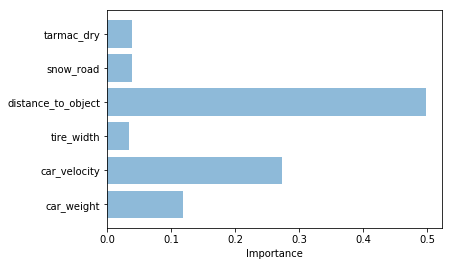

In [15]:
# ランダムフォレストモデルにおける重要度を確認。
# ランダムフォレストの場合、このようにどの説明変数が予測結果に寄与するか分かる。
features = ['car_weight', 'car_velocity', 'tire_width', 'distance_to_object',\
            'snow_road', 'tarmac_dry']
plt.barh(range(len(features)), best_clf_rf.feature_importances_,\
         align='center', alpha = 0.5)
plt.yticks( range( len(features) ), features )
plt.xlabel('Importance')
plt.show()

### ⑦－３：再現率と適合率のトレードオフ確認と閾値設定
ここまではモデルにクラスを予測させていましたが、ここではクラスごとの確率を予測させます。<br>
predict()に代わって、predict_proba()を使って確率を予測します。<br>
予測確率が閾値を超えたときに、そのクラスに該当するものと予測します。<br>
閾値を1%刻みで変更しながら正解率、再現率、適合率の変化を確認します。<br>
利用シーンを考えるとブレーキを踏まなければならないときに踏むことが重要なので、再現率を重視したほうが良いでしょう。<br>
そこで、再現率が99%になる閾値を探します。<br>
再現率を99%にそろえた時に、SVMの方がランダムフォレストより適合率が高いためよいモデルといえます。<br>

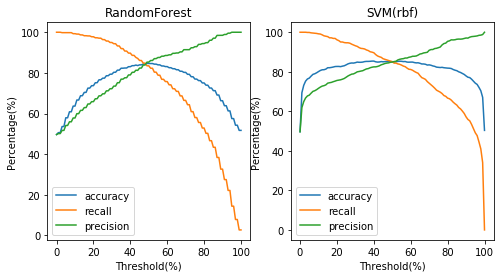

In [16]:
# 再現率と適合率のトレードオフ確認用の関数を作成
def change_threshold(val_y, pred_proba_val_y):
    # val_yは、検証データの教師ラベル
    # pred_proba_val_yは、検証データの予測確率
    val_acc_list = []
    val_prec_list = []
    val_rec_list = []
    for thres_p in range(101): # 0%から100%まで1%刻みで閾値変更
        # 予測確率pが閾値以上ならば1、そうでないならば0
        pred_val_y = [1. if p >= thres_p / 100. else 0. for p in pred_proba_val_y]
        temp_cm = confusion_matrix(val_y, pred_val_y) # 混合行列作成
        val_acc = (temp_cm[0][0] + temp_cm[1][1]) / np.sum(temp_cm) * 100.
        val_acc_list.append(val_acc) # 正解率をリストに追加
        val_prec = (temp_cm[1][1] + 1.e-18) / (temp_cm[0][1] + temp_cm[1][1] + 1.e-18) * 100.
        val_prec_list.append(val_prec) # 適合率をリストに追加
        val_rec = (temp_cm[1][1]) / np.sum(temp_cm[1]) * 100.
        val_rec_list.append(val_rec) # 再現率をリストに追加
    return val_acc_list, val_prec_list, val_rec_list

pred_proba_val_y = best_clf_rf.predict_proba(val_x)[:, 1] # 確率を予測
val_acc_rf, val_prec_rf, val_rec_rf = change_threshold(val_y, pred_proba_val_y)

pred_proba_val_y = best_clf_svm.predict_proba(val_x)[:, 1] # 確率を予測
val_acc_svm, val_prec_svm, val_rec_svm = change_threshold(val_y, pred_proba_val_y)

plt.figure(figsize = (8, 4)) # 図の大きさ指定
plt.subplot(1, 2, 1) # 1行2列の図を作成。以降、まずは1つ目の図を指定
plt.title("RandomForest") # タイトル追加
plt.plot(val_acc_rf, label = 'accuracy')   # ランダムフォレストの正解率
plt.plot(val_rec_rf, label = 'recall')     # ランダムフォレストの再現率
plt.plot(val_prec_rf, label = 'precision') # ランダムフォレストの適合率  
plt.xlabel('Threshold(%)')   # x軸名
plt.ylabel('Percentage(%)')  # y軸名
plt.legend() # 凡例追加
plt.subplot(1, 2, 2) # ２つ目の図を指定
plt.title("SVM(rbf)") # タイトル追加
plt.plot(val_acc_svm, label = 'accuracy')   # SVMの正解率
plt.plot(val_rec_svm, label = 'recall')     # SVMの再現率
plt.plot(val_prec_svm, label = 'precision') # SVMの適合率 
plt.xlabel('Threshold(%)')  # x軸名
plt.ylabel('Percentage(%)') # y軸名
plt.legend() # 凡例追加
plt.show() # 図の描画

## ⑧テストデータを用いた評価
閾値を12%にしたときに検証データで再現率が99%となりました。<br>
この閾値を用いて、評価データでの結果を確認します。<br>
ここでは、混合行列で結果を出力していますが、必要に応じて正解率、再現率、適合率、F値などを計算してみましょう。<br>

In [17]:
print ("-Testing------------------")
pred_proba_test_y = best_clf_svm.predict_proba(test_x)[:,1] # ベストなSVMで確率を予測
# 閾値12%の時に際銀率99%を期待できることをval_rec_svm変数で確認。
# 閾値12%以上でラベルを１、12%未満で0と予測
pred_val_y = [1. if p >= 12. / 100. else 0. for p in pred_proba_test_y]
# 閾値12%の際の混合行列を計算、出力
temp_cm = confusion_matrix(test_y, pred_val_y)
print(temp_cm)

-Testing------------------
[[629 363]
 [ 18 990]]


In [18]:
# モデルを保存する
filename = 'ml_svm_model.sav'
pickle.dump( best_clf_svm, open(filename, 'wb') )
filename = 'ml_rf_model.sav'
pickle.dump( best_clf_rf, open(filename, 'wb') )